In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import sys

# Import Data

In [2]:
## Read in all files from TAQ

# Fix forward/backslashes in directory name
taq_folder = '../data/taq/'
if sys.platform != 'linux':
    taq_folder = taq_folder.replace('/', '\\')
print(f'Reading data from: {taq_folder}')

# Read files
taq_files = [x[2] for x in os.walk(taq_folder)][0]
ticker_df = pd.concat([pd.read_csv(taq_folder + taq_file) for taq_file in taq_files])

Reading data from: ../data/taq/


In [3]:
# Concatenated file info
print('Tickers: ' + ', '.join(ticker_df['SYM_ROOT'].unique()))
print('Dates: ' + ', '.join(np.sort(ticker_df['DATE'].astype(str).unique())))

ticker_df.head()

Tickers: IEF, IEI, SHY, TLH, TLT
Dates: 20200103, 20200219, 20200408, 20200520, 20200701, 20200819


,DATE,TIME_M,EX,SYM_ROOT,SYM_SUFFIX,PRICE
0,20200219,9:30:00.080482083,Q,IEF,NaN,113.37
1,20200219,9:30:00.500511827,Y,IEF,NaN,113.36
2,20200219,9:30:00.500512432,K,IEF,NaN,113.36
3,20200219,9:30:00.962940345,Q,IEF,NaN,113.37
4,20200219,9:30:00.962955293,Q,IEF,NaN,113.37


# Clean Data

## Fix/Add columns

In [4]:
# Sort columns
ticker_df = ticker_df.sort_values(by = ['DATE'])

# Rename columns
ticker_df.rename(columns = {'SYM_ROOT': 'ticker', 'PRICE': 'price'}, inplace = True)

In [5]:
## Ticker Descriptions
# Long ticker descriptions
ticker_desc_dict = {
    "SHY": "iShares 1-3 Year Treasury Bond ETF",
    "IEI": "iShares 3-7 Year Treasury Bond ETF",
    "IEF": "iShares 7-10 Year Treasury Bond ETF",
    "TLH": "iShares 10-20 Year Treasury Bond ETF",
    "TLT": "iShares 20+ Year Treasury Bond ETF",
}

ticker_df["ticker_desc"] = ticker_df["ticker"].apply(lambda x: ticker_desc_dict.get(x, "NA"))

# Add short descriptions
short_desc_dict = dict(
    zip(
        ["SHY", "IEI", "IEF", "TLH", "TLT"],
        ["1-3 Year", "3-7 Year", "7-10 Year", "10-20 Year", "20+ Year"],
    )
)
ticker_df["ticker_desc_short"] = ticker_df["ticker"].apply(
    lambda x: short_desc_dict.get(x)
)

In [6]:
# Drop weird exchange
ticker_df = ticker_df.query('EX != "D"').copy()

In [6]:
# Convert date and time info to pandas datetime
ticker_df["datetime"] = pd.to_datetime(ticker_df['DATE'].astype(str) + ' ' + ticker_df['TIME_M'])
ticker_df['date'] = (ticker_df['datetime'].dt.date).astype(str)

## Resample prices

In [7]:
sampling_freq = "5s"

# Resample on a given basis
ticker_5s_df = (
    ticker_df.set_index("datetime")
    .groupby(["ticker", "ticker_desc", "ticker_desc_short", "date"])
    .resample(sampling_freq)["price"]
    .last()
    .reset_index()
)

# Forward fill missing prices for particular intervals using last observed price
ticker_5s_df["price"] = (
    ticker_5s_df.sort_values(by="datetime")
    .groupby(["ticker", "ticker_desc", "ticker_desc_short", "date"])["price"]
    .fillna(method="ffill")
)

# Add returns
ticker_5s_df = ticker_5s_df.sort_values(by=["ticker", "date", "datetime"])
ticker_5s_df["log_price"] = np.log(ticker_5s_df["price"])
ticker_5s_df["return"] = ticker_5s_df.groupby(["ticker", "date"])["log_price"].diff(1).fillna(0)

In [8]:
sampling_freq = "1s"

# Resample on a given basis
ticker_1s_df = (
    ticker_df.set_index("datetime")
    .groupby(["ticker", "ticker_desc", "ticker_desc_short", "date"])
    .resample(sampling_freq)["price"]
    .last()
    .reset_index()
)

# Forward fill missing prices for particular intervals using last observed price
ticker_1s_df["price"] = (
    ticker_1s_df.sort_values(by="datetime")
    .groupby(["ticker", "ticker_desc", "ticker_desc_short", "date"])["price"]
    .fillna(method="ffill")
)
# Add returns
ticker_1s_df = ticker_1s_df.sort_values(by=["ticker", "date", "datetime"])
ticker_1s_df["log_price"] = np.log(ticker_1s_df["price"])
ticker_1s_df["return"] = ticker_1s_df.groupby(["ticker", "date"])["log_price"].diff(1).fillna(0)

## Add realized volatility to 5s data

In [9]:
# Fix datetime column and sort data
ticker_5s_df['datetime'] = pd.to_datetime(ticker_5s_df['datetime'])
ticker_5s_df = ticker_5s_df.sort_values(by = ['ticker', 'date', 'datetime'])

In [49]:
# Sort
ticker_5s_df = ticker_5s_df.sort_values(by=["ticker", "date", "datetime"])

# Calculate sample returns
ticker_5s_df["return_5s"] = ticker_5s_df.groupby(["ticker", "date"])["log_price"].diff(1)
ticker_5s_df["return_60s"] = ticker_5s_df.groupby(["ticker", "date"])["log_price"].diff(12)

# We do Coarse Sampling here
# kn: number of gap between coarse observations
# L: the largest multiple of kn*data-frequency, i.e. floor(interval_length/kn*data-frequency)

# In this example
# data-frequency=5sec; kn=12(use 1min observation); L=floor(5min/12*5sec)=5(every interval length to calculate RV is 5-min)
def realized_var(returns):

    return np.sum(np.square(np.array(returns)))


def realized_var_sub(returns, kn=12, L=5):

    n = len(returns)
    output = np.zeros(n)

    for i in range(0, n):
        # If i corresponds to an index where we can get at least L observations
        if i - kn * L < 0:
            output[i] = np.nan
        else:
            output[i] = realized_var(returns[i - kn * L : i : kn])

    return output


# Calculate subsample realized volatility (takes a while)
tqdm.pandas()
ticker_5s_df["rv_sub"] = ticker_5s_df.groupby(["ticker", "date"])["return_60s"].progress_transform(
    realized_var_sub
)

# Average to get subavg RV
# rolling=kn=12(every coarse interval(1min) has 12 observation(5sec), each observation will give us a subsample RV
# by doing average of subsample RV within a coarse interval observation, we are able to get another measure of RV but using more data
ticker_5s_df["two_scale_realized_var_biased"] = (
    ticker_5s_df.sort_values(by=["datetime"])
    .groupby(["ticker", "date"])["rv_sub"]
    .rolling(12)
    .mean()
    .reset_index([0, 1], drop=True)
) 

The estimator is:
$$ \hat{\sigma}_\chi^2 = \frac{1}{2n} \cdot \sum_{j=1}^n ( Y_j^n - Y_{j-1}^n)^2$$
Putting all the peices together, we get the Two-Scale Realized Variance (TSRV) estimator:
$$ RV^{TSRV} = \left[ \frac{1}{k_n} \sum_{j=0}^{k_n-1}   RV_j \right] - \frac{2n}{k_n} \hat{\sigma}_x^2  $$
(Guil's notes)

In [51]:
## Corrections
# Bias correction
n = 60
kn = 12


def sigma_2_hat(returns):
    return np.sum(np.square(np.array(returns))) / (2 * len(returns))


ticker_5s_df["sigma_2_hat"] = (
    ticker_5s_df.sort_values(by=["datetime"])
    .groupby(["ticker", "date"])["return_5s"]
    .rolling(n)
    .progress_apply(sigma_2_hat)
    .reset_index([0, 1], drop=True)
)

ticker_5s_df["two_scale_realized_var"] = ticker_5s_df["two_scale_realized_var_biased"] - (
    ticker_5s_df["sigma_2_hat"] * (2 * n / kn)
)

# Time scaling
ticker_5s_df["two_scale_realized_var"] = ticker_5s_df["two_scale_realized_var"] * (6.5 * 60 / 5)

In [52]:
## Volatility Conversions
ticker_5s_df["two_scale_realized_vol"] = np.sqrt(
    ticker_5s_df["two_scale_realized_var"].apply(lambda x: np.max([x, 0]))
)
ticker_5s_df["two_scale_realized_vol_100"] = ticker_5s_df["two_scale_realized_vol"] * 100

The de-biasing step does not prevent $RV^{TSRV} < 0$ 

In [53]:
ticker_5s_df.groupby(['date'])['two_scale_realized_var'].describe()

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2020-01-03,22985.0,0.000011,0.000034,-0.000053,6.564407e-07,2.285011e-06,0.000008,0.000635
2020-02-19,22984.0,0.000005,0.000013,-0.000015,7.999100e-08,7.166166e-07,0.000003,0.000181
2020-04-08,22984.0,0.000023,0.000066,-0.000052,7.733576e-07,3.005474e-06,0.000016,0.001041
2020-05-20,22984.0,0.000011,0.000025,-0.000011,3.905530e-07,1.427589e-06,0.000011,0.000331
2020-07-01,22985.0,0.000012,0.000024,-0.000005,5.753750e-07,1.701834e-06,0.000010,0.000212
2020-08-19,22984.0,0.000014,0.000042,-0.000010,4.369553e-07,1.607710e-06,0.000010,0.000463


In [54]:
ticker_5s_df.groupby(['date'])['two_scale_realized_vol_100'].describe()

,count,mean,std,min,25%,50%,75%,max
date,,,,,,,,
2020-01-03,22985.0,0.226820,0.240960,0.0,0.081021,0.151163,0.288215,2.520181
2020-02-19,22984.0,0.135694,0.163833,0.0,0.028283,0.084653,0.175863,1.345458
2020-04-08,22984.0,0.310273,0.365539,0.0,0.087941,0.173363,0.402927,3.226963
2020-05-20,22984.0,0.221947,0.248080,0.0,0.062494,0.119482,0.325032,1.820638
2020-07-01,22985.0,0.236147,0.244187,0.0,0.075853,0.130454,0.322108,1.456554
2020-08-19,22984.0,0.233832,0.285232,0.0,0.066103,0.126796,0.316809,2.152074


# View Data

## Info

In [55]:
ticker_5s_df.head()

,ticker,ticker_desc,ticker_desc_short,date,datetime,price,log_price,return,return_5s,return_60s,rv_sub,two_scale_realized_var,sigma_2_hat,two_scale_realized_var_biased,two_scale_realized_vol,two_scale_realized_vol_100
0,IEF,iShares 7-10 Year Treasury Bond ETF,7-10 Year,2020-01-03,2020-01-03 09:30:00,111.15,4.710881,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,IEF,iShares 7-10 Year Treasury Bond ETF,7-10 Year,2020-01-03,2020-01-03 09:30:05,111.16,4.710971,0.00009,0.00009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,IEF,iShares 7-10 Year Treasury Bond ETF,7-10 Year,2020-01-03,2020-01-03 09:30:10,111.16,4.710971,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IEF,iShares 7-10 Year Treasury Bond ETF,7-10 Year,2020-01-03,2020-01-03 09:30:15,111.15,4.710881,-0.00009,-0.00009,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,IEF,iShares 7-10 Year Treasury Bond ETF,7-10 Year,2020-01-03,2020-01-03 09:30:20,111.15,4.710881,0.00000,0.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
ticker_1s_df.head()

,ticker,ticker_desc,ticker_desc_short,date,datetime,price,log_price,return
0,IEF,iShares 7-10 Year Treasury Bond ETF,7-10 Year,2020-01-03,2020-01-03 09:30:00,111.15,4.710881,0.0
1,IEF,iShares 7-10 Year Treasury Bond ETF,7-10 Year,2020-01-03,2020-01-03 09:30:01,111.15,4.710881,0.0
2,IEF,iShares 7-10 Year Treasury Bond ETF,7-10 Year,2020-01-03,2020-01-03 09:30:02,111.15,4.710881,0.0
3,IEF,iShares 7-10 Year Treasury Bond ETF,7-10 Year,2020-01-03,2020-01-03 09:30:03,111.15,4.710881,0.0
4,IEF,iShares 7-10 Year Treasury Bond ETF,7-10 Year,2020-01-03,2020-01-03 09:30:04,111.15,4.710881,0.0


In [57]:
ticker_5s_df.groupby('ticker').count()

,ticker_desc,ticker_desc_short,date,datetime,price,log_price,return,return_5s,return_60s,rv_sub,two_scale_realized_var,sigma_2_hat,two_scale_realized_var_biased,two_scale_realized_vol,two_scale_realized_vol_100
ticker,,,,,,,,,,,,,,,
IEF,28080,28080,28080,28080,28080,28080,28080,28074,28008,27648,27582,27720,27582,27582,27582
IEI,28080,28080,28080,28080,28080,28080,28080,28074,28008,27648,27582,27720,27582,27582,27582
SHY,28080,28080,28080,28080,28080,28080,28080,28074,28008,27648,27582,27720,27582,27582,27582
TLH,28076,28076,28076,28076,28076,28076,28076,28070,28004,27644,27578,27716,27578,27578,27578
TLT,28080,28080,28080,28080,28080,28080,28080,28074,28008,27648,27582,27720,27582,27582,27582


In [58]:
ticker_5s_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140396 entries, 0 to 140395
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   ticker                         140396 non-null  object        
 1   ticker_desc                    140396 non-null  object        
 2   ticker_desc_short              140396 non-null  object        
 3   date                           140396 non-null  object        
 4   datetime                       140396 non-null  datetime64[ns]
 5   price                          140396 non-null  float64       
 6   log_price                      140396 non-null  float64       
 7   return                         140396 non-null  float64       
 8   return_5s                      140366 non-null  float64       
 9   return_60s                     140036 non-null  float64       
 10  rv_sub                         138236 non-null  float64       
 11  

## Plots

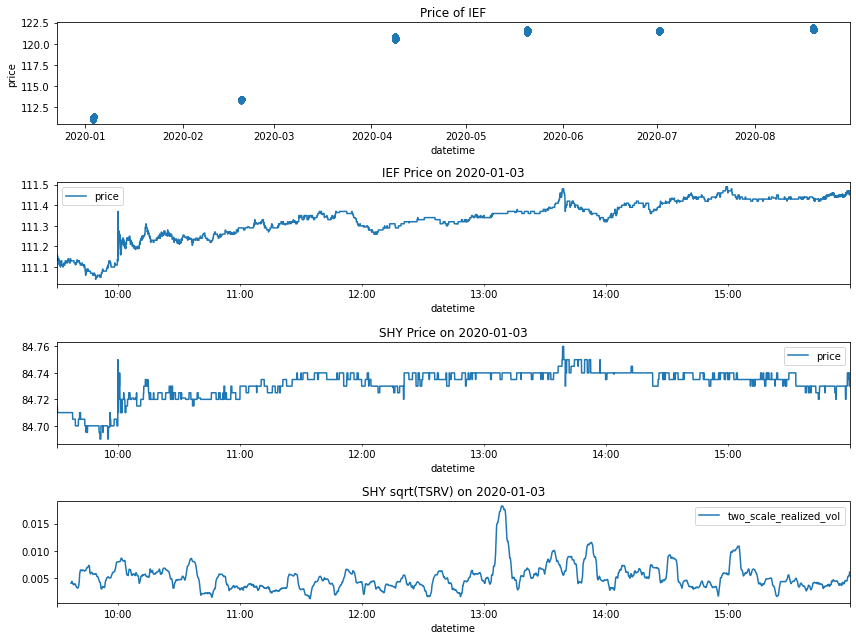

In [59]:
fig, ax = plt.subplots(figsize=(12, 9), nrows=4)

ax = plt.subplot(4, 1, 1)
ticker_1s_df.query('ticker == "IEF"').plot.scatter(x="datetime", y="price", ax=ax)
plt.title("Price of IEF")

ax = plt.subplot(4, 1, 2)
ticker_1s_df.query('ticker == "IEF" & date == "2020-01-03"').plot(x="datetime", y="price", ax=ax)
plt.title("IEF Price on 2020-01-03")

ax = plt.subplot(4, 1, 3)
ticker_5s_df.query('ticker == "SHY" & date == "2020-01-03"').plot(x="datetime", y="price", ax=ax)
plt.title("SHY Price on 2020-01-03")

ax = plt.subplot(4, 1, 4)
ticker_5s_df.query('ticker == "TLT" & date == "2020-05-20"').plot(
    x="datetime", y="two_scale_realized_vol", ax=ax
)
plt.title("SHY sqrt(TSRV) on 2020-01-03")

plt.tight_layout()

# Export Data

In [60]:
ticker_df.to_csv('../data/clean/ticker.csv', index = False)
ticker_1s_df.to_csv('../data/clean/ticker_1s.csv', index = False)
ticker_5s_df.to_csv('../data/clean/ticker_5s.csv', index = False)